# Load libraries and read data

In [0]:
!pip install shap
!pip install pyitlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.path.abspath(os.getcwd())
os.chdir('/content/drive/My Drive/Protein project')
os.path.abspath(os.getcwd())

from __future__ import division ###for float operation
from collections import Counter
from numpy import *
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score ##tp / (tp + fn)
from sklearn.metrics import precision_score #tp / (tp + fp)
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import KFold, StratifiedKFold
from pyitlib import discrete_random_variable as drv
import time 
import timeit 

In [0]:
class NotFittedError(ValueError):
    """Raise if predict is called before fit."""

    def __init__(self, class_name):
        message = self.message(class_name)
        super(NotFittedError, self).__init__(message)

    @staticmethod
    def message(class_name):
        return ("This instance of " + class_name +
                " has not been fitted yet. Please call "
                "'fit' before you call 'predict'.")


This goes back to the amino acid sequence
vs the 8 blocks that we discussed last week.
The set of pairs [(254, 256), (52, 115), (215, 218), (72, 92), (146, 213),....] is talking about physical touch in
the amino acid sequence and it means positions
254 and 256, 52 and 115, 215 and 218, e.t.c
are physically touching.
The way the 8 x 8 matrix is calculated is to add
up all the positions within and between blocks that
are physically touching. For example, say 254 and
256 are both in block 4, the (254, 256)  would add 1 to the [4,4]
entry of the 8 x 8 block matrix, if 52 was in block 1 and
115 was in block 2, the (52, 115) would add 1 to
the [1,2] and [2,1] entries of the matrix. 

So to go from the set of pairs to the 8 x 8 contact
matrix, you need to go back to the alignments, use
the amino acid sequence pairs and add up how many
are in each pair of blocks.

-----by Garvesh



### P450

In [0]:
def readData(filename):
	fr = open(filename)
	returnData = []
	headerLine=fr.readline()###move cursor 
	for line in fr.readlines():
		lineStrip = line.strip().replace('"','')
		lineList =	lineStrip.split('\t')
		returnData.append(lineList)###['3','2',...]
	return returnData

"""first case P450 = [['1','1',....],[],[].....,[]]  second case P450 = array([['1','1',....],[],[].....,[]]), third case P450 = """
P450 = readData('P450.txt') ### [[],[],[],....[]]
P450 = np.array(P450) ### either [['1','1',....],[],[].....,[]] or array([['1','1',....],[],[].....,[]]) works, but note that keys are '1', '0' 
P450 = P450.astype(int) ### for shap array [[1,1,....],[],[].....,[]], keys are 1, 0 

M=matrix([[245,   9,   0,   3,   0,   2,  65,   8],
[9, 218,  17,  17,  49,  10,  50,  17],
[0,  17, 175,  16,  25,  13,   0,  46],
[3,  17,  16, 194,  19,   0,   0,   3],
[0,  49,  25,  19, 199,  10,   0,   3],
[2,  10,  13,   0,  10, 249,  50,  74],
[65,  50,   0,   0,   0,  50, 262,  11],
[8,  17,  46,   3,   3,  74,  11, 175]])

### lactamase

In [0]:
def readData2(filename):
	fr = open(filename)
	returnData = []
	headerLine=fr.readline()###move cursor 
	for line in fr.readlines():
		linestr = line.strip().replace(', ','')
		lineList =	list(linestr)
		returnData.append(lineList)###['3','2',...]
	return returnData

lactamase = readData2('lactamase.txt')
lactamase = np.array(lactamase)
lactamase = lactamase.astype(int)
M2 = matrix([[101, 5, 0, 2, 0, 14, 4, 37],
[5 ,15, 14 ,1 ,7 ,7, 0 ,19],
[0, 14, 266, 15, 14, 2, 26, 4],
[2, 1, 15, 28, 2 ,15, 4, 0],
[0, 7, 14, 2, 32, 9 ,0, 8],
[14, 7, 2 ,15, 9, 29, 7, 9],
[4, 0, 26, 4 ,0 ,7 ,72, 21],
[37, 19, 4, 0, 8, 9, 21, 211]])


### lymph

In [0]:
def readarff(filename):
  arrfFile = open(filename)
  lines = [line.rstrip('\n') for line in arrfFile]
  data = [[]]
  index = 0
  for line in lines :
      if(line.startswith('@attribute')) :
          index+=1
      elif(not line.startswith('@data') and not line.startswith('@relation') and not line.startswith('%')) :
          data.append(line.split(','))
  del data[0]
  return data


lymph_train = readarff("github_bn_code/lymph_train.arff.txt"); lymph_train = np.array(lymph_train)  
lymph_test = readarff("github_bn_code/lymph_test.arff.txt") ;lymph_test = np.array(lymph_test)

lymph = np.concatenate((lymph_train,lymph_test))



### Vote

In [0]:
vote_train = readarff("github_bn_code/vote_train.arff.txt") ;vote_train = np.array(vote_train)
vote_test = readarff("github_bn_code/vote_test.arff.txt")  ; vote_test = np.array(vote_test)

vote = np.concatenate((vote_train,vote_test))

# API Bayesian network class

For using shap purpose, write skilearn API class, 


## Base class

In [0]:
"""
Bayesian network implementation
API inspired by SciKit-learn.
"""

class Bayes_net(object): ### DO I need object???
    def __init__(self, alpha = 1):
      """Create a Bayesian classifier
      alpha is the smoothing parameter
      name is the class name of that classifier: Naive Bayes, Tree augmented naive Nayes
      Dict_C, p , P_class_prior,C K,countDict are learned from fitting method. Initialized as empty list.
      """
      self.alpha = alpha
      self.name = self.get_name()

      self.Dict_C = []
      self.p = 0
      self.P_class_prior = []
      self.K = []
      self.C = []
      self.countDict = []
      self._is_fitted = False

      """add training time """
      self.training_time = 0


    def get_name(self):
      raise NotImplementedError

    def get_Y(self,train):  
      """Get target values from train data.
      :param train: Training examples with dimension (p+1) x n,
                    where n is the number of examples,
                    and p is the number of features. 
                    Last column is target.(dtype: list)
      :return: target values(dtype: list/array)
      """
      if isinstance(train,list):
        return([ele[-1] for ele in train])
      else: ### suppose it is array
        return(train[:,-1])

    def get_X(self,train):
      """Get feature values from train data.
      :param train: Training examples with dimension (p+1) x n,
                    where n is the number of examples,
                    and p is the number of features. 
                    Last column is target.(dtype: list)
      :return: feature matrix(dtype: list[[ ],[ ],[ ],....[ ]] or array) 
      """
      if isinstance(train,list):
        p = len(train[0]) - 1
        return([ele[0:p] for ele in train])
      else:
        p = len(train[0]) - 1
        return(train[:,0:p])

    def prob_to_class_general(self,y_pred_prob,C): 
      """convert predicted probabilities to class labels.
      :param y_pred_prob: np.array shows prob of each class for each instance. ith column is the predicted prob for class C[i]
      :param C: Class labels 
      :return: predicted class labels.(dtype:array).    if C = ['1','0'], then returns list like array(['1','1','0'])
      """

      return( np.array([C[ele] for ele in np.argmax(y_pred_prob, axis=1)] ) ) 

    def Conditional_log_likelihood_general(self,y_true,y_pred_prob,C): 
      """Calculate the conditional log likelihood.
      :param y_true: The true class labels. e.g ['1','1',.....'0','0']
      :param y_pred_prob: np.array shows prob of each class for each instance. ith column is the predicted prob for class C[i]
      :param C: Class labels  e.x ['1','0'], C has to use same labels as y_true.
      :return: CLL. A scalar.
      """
      cll = []
      for i in range(len(y_true)):
        cll.append( y_pred_prob[i,C.index(y_true[i])] ) ## \hat p(c_true|c_true)
      
      cll = [np.log2(ele) for ele in cll]
      cll = np.array(cll)
      return(sum(cll))

    def fit(self,train):
      """Reset the parameters to none, and Fit model according to train data.
        :param train: Training examples with dimension (p+1) x n,
                      where n is the number of examples,
                      and p is the number of features. 
                      Last column is target.(dtype: list)
        :return: self
      """
      raise NotImplementedError
    
    def predict(self, test):
      """Predict prob values for test set for each class.
        :param test_set: Test set with dimension (p or p+1) x n,
                         where n is the number of examples,
                         and p is the number of features.
        :return: Predicted target values for test set with dimension n * |C|, 
                 where n is the number of examples. |C| is the # of classes. 
                 it is np.array shows prob of each class for each instance. ith column is the predicted prob for class C[i]
        """
      raise NotImplementedError
    
    def predict_binary(self,test):
      raise NotImplementedError

    def predict_class(self, test):
      """Predict class labels for test set .
        :param test_set: Test set with dimension (p or p+1) x n,
                         where n is the number of examples,
                         and p is the number of features.
        :return: Predicted class labels for test set with dimension n ,
                 where n is the number of examples.  
        """
      Prob_C = self.predict(test) ## Prob_C is |C|*n np.array ,C is self.C 
      return(self.prob_to_class_general(Prob_C,self.C))


 

## Naive Bayes

In [0]:
class NB(Bayes_net):


  def get_name(self):
    return("NB")

  def fit(self,train):  
    Y = self.get_Y(train)
    t = time.process_time()
    """start timing"""
    countDict = Counter(Y) ## {c1:n1,c2:n2,c3:n3} sorted by counts
    C = list(countDict.keys()) ### [class1 , class2, class3] in appearing order
    p = len(train[0]) - 1    ## num of features 8                                  ### .values same order as .keys()
    P_class = [(ele+self.alpha)/(sum(list(countDict.values())) + self.alpha*len(C) )  for ele in countDict.values()]  ### prior for each class [p1,p2,p3]
    P_class = dict(zip(C, P_class))  ## {c1:p1,c2:p2,c3:p3} ## should in correct order, .keys .values.
    Dict_C = {} ###  {c1:[counter1, ....counter8], c2:[counter1, ....counter8],   c3: [counter1, ....counter8]}
    K = {} ## [x1 unique , x2 unique .... x8unique]

    for c in C:
      ListCounter_c = []

      for i in range(p):
        x_i_c = [ele[i] for ele in train if ele[-1] == c]
        ListCounter_c.append(Counter(x_i_c))
        if c == C[0]:
          x_i = [ele[i] for ele in train]
          K[i] = len(Counter(x_i))

      Dict_C[c] = ListCounter_c
    
    CP_time = time.process_time() - t; CP_time = np.array(CP_time)
    self._is_fitted = True
    self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict,self.training_time = Dict_C,p,P_class,K,C,countDict,CP_time
    return self


  def predict(self,X_test): 
    """Predict prob values for test set for each class.
        :param test_set: Test set with dimension (p or p+1) x n,
                         where n is the number of examples,
                         and p is the number of features.
        :return: Predicted target values for test set with dimension n * |C|, 
                 where n is the number of examples. |C| is the # of classes. 
                 it is np.array shows prob of each class for each instance. ith column is the predicted prob for class C[i]
        """
    if not self._is_fitted:
      raise NotFittedError(self.__class__.__name__)

    Prob_C = []
    for ins in X_test:
      P_class = self.P_class_prior.copy() ### {c1:p1, c2:p2} #### !!!! dict1 = dict2 , change both simultaneously!!!
      for c in self.C:
        ListCounter_c = self.Dict_C[c]
        for i in range(self.p):
          P_class[c] = P_class[c] * (ListCounter_c[i][ins[i]]+self.alpha) / (self.countDict[c] + self.alpha*self.K[i])
        
      ## normalize P_class
      P_class = {key: P_class[key]/sum(list(P_class.values())) for key in P_class.keys()}
      Prob_C.append(list(P_class.values())) ### check the class order is correct
  
    Prob_C = array(Prob_C) ### for shap !!!!
    return Prob_C

  def predict_binary(self,X_test):
    Prob_C = self.predict(X_test) ### Prob_C is n*|C| np.array
    return(Prob_C[:,0]) 
    

In [0]:
nb = NB()
nb.fit(P450)
nb.fit(P450)
nb.Dict_C
print(type(nb.training_time))
#nb.training_time
#nb.predict(P450)
#nb.predict_class(P450)

<class 'numpy.ndarray'>


## TAN_MT

In [0]:
class TAN_MT(Bayes_net):
    def __init__(self, alpha = 1,starting_node = 0):
      self.starting_node = starting_node
      self.alpha = alpha
      self.name = "TAN_MT"

      self.Dict_C = []
      self.p = 0
      self.P_class_prior = []
      self.K = []
      self.C = 0
      self.countDict = []
      self.parent = [] ### one more attribute than NB

      self._is_fitted = False
      """add training time """
      self.training_time = 0
      self.mutual_inf_time = 0
      self.prim_time = 0
      self.CP_time = 0

    def To_CAT(self, X_i): 
      """For using CMI purpose, convert X_i e.g ['a','b','a']/['0','1','0']  to [0,1,0].
      :param X_i: one feature column. 
      :return: list(type int)
      """
      X_i_list = list(set(X_i));X_i_dict = dict(zip(X_i_list, arange(len(X_i_list)) ))
      return([X_i_dict[ele] for ele in X_i])

    def get_mutual_inf(self,train):
      """get conditional mutual inf of all pairs of features, part of training
      :return: np.array matrix.
      """
      t = time.process_time()
      p = len(train[0]) - 1
      M = np.zeros((p,p))
      Y = self.get_Y(train); Y = self.To_CAT(Y)
      X = self.get_X(train)
      for i in range(p):
        X_i = [ele[i] for ele in X]
        X_i = self.To_CAT(X_i)
        for j in range(p):
          X_j = [ele[j] for ele in X]; 
          X_j = self.To_CAT(X_j)
          M[i,j] = drv.information_mutual_conditional(X_i,X_j,Y)
      
      self.mutual_inf_time = time.process_time() - t
      return M

    def Findparent(self,train):
      M = self.get_mutual_inf(train)
      t = time.process_time()
      fill_diagonal(M,0)  
      p = int(M.shape[0])  
      V = range(p)  #### . set of all nodes
      st = self.starting_node
      Vnew = [st] #### vertex that already found their parent. intitiate it with starting node. TAN randomly choose one
      parent = {st:None} ## use a dict to show nodes' interdepedency
      while set(Vnew) != set(V):   ### when their are still nodes whose parents are unknown.
        index_i = [] ### after for loop, has same length as Vnew, shows the closest node that not in Vnew with Vnew.  
        max_inf = [] ### corresponding distance
        for i in range(len(Vnew)):  ## can be paralelled 
          vnew = Vnew[i]
          ListToSorted = [int(e) for e in M[:,vnew]]###
          index = sorted(range(len(ListToSorted)),key = lambda k: ListToSorted[k],reverse = True)
          index_i.append([ele for ele in index if ele not in Vnew][0]) 
          max_inf.append(M[index_i[-1],vnew])
      
        index1 = sorted(range(len(max_inf)),key = lambda k: max_inf[k],reverse = True)[0] ## relative position, Vnew[v1,v2] index_i[v4,v5] max_inf[s1,s2] index1 is the position in those 3 list
        Vnew.append(index_i[index1]) ### add in that node
        parent[index_i[index1]] = Vnew[index1] ## add direction, it has to be that the new added node is child, otherwise some nodes has 2 parents which is wrong.
      
      self.prim_time = time.process_time() - t
      return parent

    def fit(self,train):  ### this is based on trainning data !!!
      parent = self.Findparent(train)
      y = self.get_Y(train)
      t = time.process_time()
      """ start timing"""
      countDict = Counter(y)
      C = list(countDict.keys()) ### [class1 , class2, class3] in appearing order
      p = len(train[0]) - 1
      P_class = [(ele+self.alpha)/(sum(list(countDict.values())) + self.alpha*len(C) )  for ele in list(countDict.values())]  ### prior for each class [p1,p2,p3], ### .values same order as .keys()
      P_class = dict(zip(C, P_class))  ## {c1:p1,c2:p2,c3:p3} ## should in correct order, .keys .values.
      Dict_C = {} ###  {c1:[counter1, ....counter8], c2:[counter1, ....counter8],   c3: [counter1, ....counter8]}
      K = {}

      root_i = self.starting_node ## 0 ,1 ,2 shows the position, thus int
      x_i = [ele[root_i] for ele in train]
      K[root_i] = len(Counter(x_i))
      for c in C: ### c origianl class label '1'   not 1
        ListCounter_c = {}
        x_i_c = [ele[root_i] for ele in train if ele[-1] == c]
        ListCounter_c[root_i] = Counter(x_i_c) ### list_counter_c keys are 0,1,2,3... showing position hence int. Counter(x_i_c) keys are original values of x, not position. hence not necesarily int
        for i in [e for e in range(0,p) if e != root_i]:
          if c == C[0]:
            x_i = [ele[i] for ele in train]
            K[i] =len(Counter(x_i))
          x_parent = [ele[parent[i]] for ele in train] ## will duplicate C times. 
          x_parent_counter = Counter(x_parent)
          x_parent_counter_length = len(x_parent_counter)
          x_parent_value = list(x_parent_counter.keys())
          dict_i_c = {}
          for j in range(x_parent_counter_length):
            x_i_c_p_j = [ele[i] for ele in train if ele[-1] == c and ele[parent[i]] == x_parent_value[j] ]
            dict_i_c[x_parent_value[j]] = Counter(x_i_c_p_j) ### x_parent_value[j] can make sure it is right key.
          ListCounter_c[i] = dict_i_c
        Dict_C[c] = ListCounter_c 

      CP_time = time.process_time() - t
      self._is_fitted = True
      self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict, self.parent,self.CP_time = Dict_C,p,P_class,K,C,countDict,parent,CP_time
      self.training_time = np.array([self.mutual_inf_time,self.prim_time,self.CP_time])
      return self

    def predict(self,test):	
      """Predict prob values for test set for each class.
        :param test_set: Test set with dimension (p or p+1) x n,
                         where n is the number of examples,
                         and p is the number of features.
        :return: Predicted target values for test set with dimension n * |C|, 
                 where n is the number of examples. |C| is the # of classes. 
                 it is np.array shows prob of each class for each instance. ith column is the predicted prob for class C[i]
      """
      if not self._is_fitted:
        raise NotFittedError(self.__class__.__name__) ### after fitting, self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict, self.parent

      Prob_C = []
      root_i = self.starting_node

      for ins in test:
        P_class = self.P_class_prior.copy()
        for c in self.C:
          ListCounter_c = self.Dict_C[c]
          P_class[c] = P_class[c] * (ListCounter_c[root_i][ins[root_i]]+self.alpha) / (self.countDict[c]+self.alpha*self.K[root_i])
        
          for i in [e for e in range(0,self.p) if e != root_i]:
            pValue = ins[self.parent[i]] ### replicate C times
            try:###  ListCounter_c[i][pValue],pavlue does show in training
              Deno = sum(list(ListCounter_c[i][pValue].values() )) ## number of y =1, xparent = pvalue ,   ListCounter_c[i][pValue], pavlue does not show in training , keyerror
              P_class[c] = P_class[c] * (ListCounter_c[i][pValue][ins[i]] + self.alpha) / (Deno + self.alpha*self.K[i]) ## ListCounter1[i][pValue][ins[i]] = number of y =1 xparent = pvalue, xi = xi
            except: ##ListCounter_c[i][pValue],pavlue does not show in training
              Deno = 0 ## ListCounter_c[i] this is when class == c, ith feature,  >> {parent(i) == value1: Counter,  parent(i) == value2: Counter  },  counter shows the distribution of x_i when class ==c and parent == pvalue
              P_class[c] = P_class[c] * (0 + self.alpha) / (Deno + self.alpha*self.K[i])
        
        P_class = {key: P_class[key]/sum(list(P_class.values())) for key in P_class.keys()} ### normalize p_class
        Prob_C.append(list(P_class.values())) ### check the class order is correct

      Prob_C = array(Prob_C) ### for shap !!!!
      return Prob_C

    def predict_binary(self,test):
      Prob_C = self.predict(test)
      return(Prob_C[:,0]) 


In [0]:
tan_mt = TAN_MT()
print(tan_mt.parent)

tan_mt.fit(P450)
print(tan_mt.parent)
print(type(tan_mt.training_time))
tan_mt.countDict
#tan_mt.Dict_C['1']
tan_mt.predict(P450)
#tan_mt.training_time

[]
{0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 6}
<class 'numpy.ndarray'>


array([[0.86147555, 0.13852445],
       [0.90809796, 0.09190204],
       [0.92478606, 0.07521394],
       ...,
       [0.23448663, 0.76551337],
       [0.21158355, 0.78841645],
       [0.77417023, 0.22582977]])

##TAN 

In [0]:
class TAN(Bayes_net):
    def __init__(self,Matrix,alpha = 1,starting_node = 0):
      self.starting_node = starting_node
      self.alpha = alpha
      self.name = "TAN"
      self.M = Matrix
      self.parent = self.Findparent() ## prim_time is not part from training,so I did not inlude it in training time
      
      """ training part"""
      self.Dict_C = []
      self.p = 0
      self.P_class_prior = []
      self.K = []
      self.C = 0
      self.countDict = []

      self._is_fitted = False
      """add training time """
      self.training_time = 0
      self.CP_time = 0

    
    def Findparent(self):
      M = self.M.copy()
      fill_diagonal(M,0)  
      p = int(M.shape[0])  
      V = range(p)  #### . set of all nodes
      st = self.starting_node
      Vnew = [st] #### vertex that already found their parent. intitiate it with starting node. TAN randomly choose one
      parent = {st:None} ## use a dict to show nodes' interdepedency
      while set(Vnew) != set(V):   ### when their are still nodes whose parents are unknown.
        index_i = [] ### after for loop, has same length as Vnew, shows the closest node that not in Vnew with Vnew.  
        max_inf = [] ### corresponding distance
        for i in range(len(Vnew)):  ## can be paralelled 
          vnew = Vnew[i]
          ListToSorted = [int(e) for e in M[:,vnew]]###
          index = sorted(range(len(ListToSorted)),key = lambda k: ListToSorted[k],reverse = True)
          index_i.append([ele for ele in index if ele not in Vnew][0]) 
          max_inf.append(M[index_i[-1],vnew])
      
        index1 = sorted(range(len(max_inf)),key = lambda k: max_inf[k],reverse = True)[0] ## relative position, Vnew[v1,v2] index_i[v4,v5] max_inf[s1,s2] index1 is the position in those 3 list
        Vnew.append(index_i[index1]) ### add in that node
        parent[index_i[index1]] = Vnew[index1] ## add direction, it has to be that the new added node is child, otherwise some nodes has 2 parents which is wrong.
      
      return parent

    def fit(self,train):  ### this is based on trainning data !!!
      y = self.get_Y(train)
      t = time.process_time()
      """ start timing"""
      countDict = Counter(y)
      C = list(countDict.keys()) ### [class1 , class2, class3] in appearing order
      p = len(train[0]) - 1
      P_class = [(ele+self.alpha)/(sum(list(countDict.values())) + self.alpha*len(C) )  for ele in list(countDict.values())]  ### prior for each class [p1,p2,p3], ### .values same order as .keys()
      P_class = dict(zip(C, P_class))  ## {c1:p1,c2:p2,c3:p3} ## should in correct order, .keys .values.
      Dict_C = {} ###  {c1:[counter1, ....counter8], c2:[counter1, ....counter8],   c3: [counter1, ....counter8]}
      K = {}

      root_i = self.starting_node ## 0 ,1 ,2 shows the position, thus int
      x_i = [ele[root_i] for ele in train]
      K[root_i] = len(Counter(x_i))
      for c in C: ### c origianl class label '1'   not 1
        ListCounter_c = {}
        x_i_c = [ele[root_i] for ele in train if ele[-1] == c]
        ListCounter_c[root_i] = Counter(x_i_c) ### list_counter_c keys are 0,1,2,3... showing position hence int. Counter(x_i_c) keys are original values of x, not position. hence not necesarily int
        for i in [e for e in range(0,p) if e != root_i]:
          if c == C[0]:
            x_i = [ele[i] for ele in train]
            K[i] =len(Counter(x_i))
          x_parent = [ele[self.parent[i]] for ele in train] ## will duplicate C times. 
          x_parent_counter = Counter(x_parent)
          x_parent_counter_length = len(x_parent_counter)
          x_parent_value = list(x_parent_counter.keys())
          dict_i_c = {}
          for j in range(x_parent_counter_length):
            x_i_c_p_j = [ele[i] for ele in train if ele[-1] == c and ele[self.parent[i]] == x_parent_value[j] ]
            dict_i_c[x_parent_value[j]] = Counter(x_i_c_p_j) ### x_parent_value[j] can make sure it is right key.
          ListCounter_c[i] = dict_i_c
        Dict_C[c] = ListCounter_c 

      CP_time = time.process_time() - t; CP_time = np.array(CP_time)
      self._is_fitted = True
      self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict,self.CP_time = Dict_C,p,P_class,K,C,countDict,CP_time
      self.training_time = CP_time
      return self


    def predict(self,test):	
      """Predict prob values for test set for each class.
        :param test_set: Test set with dimension (p or p+1) x n,
                         where n is the number of examples,
                         and p is the number of features.
        :return: Predicted target values for test set with dimension n * |C|, 
                 where n is the number of examples. |C| is the # of classes. 
                 it is np.array shows prob of each class for each instance. ith column is the predicted prob for class C[i]
      """
      if not self._is_fitted:
        raise NotFittedError(self.__class__.__name__) ### after fitting, self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict, self.parent

      Prob_C = []
      root_i = self.starting_node

      for ins in test:
        P_class = self.P_class_prior.copy()
        for c in self.C:
          ListCounter_c = self.Dict_C[c]
          P_class[c] = P_class[c] * (ListCounter_c[root_i][ins[root_i]]+self.alpha) / (self.countDict[c]+self.alpha*self.K[root_i])
        
          for i in [e for e in range(0,self.p) if e != root_i]:
            pValue = ins[self.parent[i]] ### replicate C times
            try:###  ListCounter_c[i][pValue],pavlue does show in training
              Deno = sum(list(ListCounter_c[i][pValue].values() )) ## number of y =1, xparent = pvalue ,   ListCounter_c[i][pValue], pavlue does not show in training , keyerror
              P_class[c] = P_class[c] * (ListCounter_c[i][pValue][ins[i]] + self.alpha) / (Deno + self.alpha*self.K[i]) ## ListCounter1[i][pValue][ins[i]] = number of y =1 xparent = pvalue, xi = xi
            except: ##ListCounter_c[i][pValue],pavlue does not show in training
              Deno = 0 ## ListCounter_c[i] this is when class == c, ith feature,  >> {parent(i) == value1: Counter,  parent(i) == value2: Counter  },  counter shows the distribution of x_i when class ==c and parent == pvalue
              P_class[c] = P_class[c] * (0 + self.alpha) / (Deno + self.alpha*self.K[i])
        
        P_class = {key: P_class[key]/sum(list(P_class.values())) for key in P_class.keys()} ### normalize p_class
        Prob_C.append(list(P_class.values())) ### check the class order is correct

      Prob_C = array(Prob_C) ### for shap !!!!
      return Prob_C

    def predict_binary(self,test):
      Prob_C = self.predict(test)
      return(Prob_C[:,0]) 


In [0]:
M=matrix([[245,   9,   0,   3,   0,   2,  65,   8],
[9, 218,  17,  17,  49,  10,  50,  17],
[0,  17, 175,  16,  25,  13,   0,  46],
[3,  17,  16, 194,  19,   0,   0,   3],
[0,  49,  25,  19, 199,  10,   0,   3],
[2,  10,  13,   0,  10, 249,  50,  74],
[65,  50,   0,   0,   0,  50, 262,  11],
[8,  17,  46,   3,   3,  74,  11, 175]])
tan = TAN(M)
print(tan.parent)
tan.fit(P450)
print(tan.parent)
print(type(tan.training_time))
tan.predict(P450)## parent


{0: None, 6: 0, 1: 6, 5: 6, 7: 5, 4: 1, 2: 7, 3: 4}
{0: None, 6: 0, 1: 6, 5: 6, 7: 5, 4: 1, 2: 7, 3: 4}
<class 'numpy.ndarray'>


array([[0.79215303, 0.20784697],
       [0.91788404, 0.08211596],
       [0.92852167, 0.07147833],
       ...,
       [0.24149027, 0.75850973],
       [0.15284187, 0.84715813],
       [0.74094713, 0.25905287]])

# Ensemble :Bagging

## Bagging TAN_MT

In [0]:
class TAN_MT_bagging(Bayes_net):
  def __init__(self, alpha = 1):
    self.alpha = alpha
    self.name = "TAN_MT_bagging"

    """base models, each having different starting node"""
    self.models = []
    self.p = 0
    self.C = []
    self._is_fitted = False
    """add training time """
    self.training_time = 0
    

  def fit(self,train): 
    """initialize model = [] . and training time."""
    p = len(train[0]) -1 ### number of features
    self.p = p
    """fit base models"""
    training_time = 0
    models = []
    for i in range(p):
      model = TAN_MT(self.alpha, starting_node= i)
      model.fit(train)
      models.append(model)
      training_time += model.training_time

    self.models = models
    self.training_time = training_time/p ### the fitting can be paralelled, hence define averge training time for this bagging
    self._is_fitted = True
    self.C = model.C
    return self

  def predict(self,test):	   
    if not self._is_fitted:
        raise NotFittedError(self.__class__.__name__) ### after fitting, self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict, self.parent

    Prob_C = 0
    for model in self.models:
      Prob_C += model.predict(test) ### get np array here 

    Prob_C = Prob_C/self.p
    return(Prob_C)

  def predict_binary(self,test):
      Prob_C = self.predict(test)
      return(Prob_C[:,0]) 
  

In [0]:
tan_mt_bag = TAN_MT_bagging()
tan_mt_bag.fit(P450)
#tan_mt_bag.fit(P450)

len(tan_mt_bag.models)

8

In [0]:
print(tan_mt_bag.models[0].parent)
print(tan_mt_bag.models[2].parent)
print(tan_mt_bag.models[7].parent)
tan_mt_bag.predict(P450) ### get_cv change behaviour
#nb.predict(P450)
#tan_mt_bag.predict_class(P450)
#tan_mt_bag.models[0].Dict_C

{0: None, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 6}
{2: None, 0: 2, 1: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 6}
{7: None, 0: 7, 1: 7, 2: 7, 3: 0, 4: 0, 5: 7, 6: 0}


array([[0.82331053, 0.17668947],
       [0.90948728, 0.09051272],
       [0.93262318, 0.06737682],
       ...,
       [0.24045922, 0.75954078],
       [0.21006017, 0.78993983],
       [0.7522166 , 0.2477834 ]])

## Bagging TAN

In [0]:
class TAN_bagging(Bayes_net):
  def __init__(self,Matrix,alpha = 1):
    self.alpha = alpha
    self.name = "TAN_bagging"
    self.M = Matrix

    """base models, each having different starting node"""
    self.models = []
    self.p = 0
    self.C = []
    self._is_fitted = False
    """add training time """
    self.training_time = 0
    

  def fit(self,train): 
    """initialize models = [] . and training time."""
    p = len(train[0]) -1 ### number of features
    self.p = p
    """fit base models"""
    training_time = 0
    models = []
    for i in range(p):
      model = TAN(self.M, self.alpha, starting_node= i)
      model.fit(train)
      models.append(model)
      training_time += model.training_time

    self.models = models
    self.training_time = training_time/p ### the fitting can be paralelled, hence define averge training time for this bagging
    self._is_fitted = True
    self.C = model.C
    return self

  def predict(self,test):	   
    if not self._is_fitted:
        raise NotFittedError(self.__class__.__name__) ### after fitting, self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict, self.parent

    Prob_C = 0
    for model in self.models:
      Prob_C += model.predict(test) ### get np array here 

    Prob_C = Prob_C/self.p
    return(Prob_C)

  def predict_binary(self,test):
      Prob_C = self.predict(test)
      return(Prob_C[:,0]) 
  

In [0]:
tan_bag = TAN_bagging(M)
tan_bag.fit(P450)
print(tan_bag.models[0].parent)
print(tan_bag.models[2].parent)
print(tan_bag.models[7].parent)
tan_bag.predict(P450)

{0: None, 6: 0, 1: 6, 5: 6, 7: 5, 4: 1, 2: 7, 3: 4}
{2: None, 7: 2, 5: 7, 6: 5, 0: 6, 1: 6, 4: 1, 3: 4}
{7: None, 5: 7, 6: 5, 0: 6, 1: 6, 4: 1, 2: 7, 3: 4}


array([[0.7917778 , 0.2082222 ],
       [0.9187195 , 0.0812805 ],
       [0.92864436, 0.07135564],
       ...,
       [0.24276788, 0.75723212],
       [0.15375769, 0.84624231],
       [0.74263807, 0.25736193]])

## TAN + TAN_MT

TAN very robust, different starting node does not make much difference. Hence randomly choose a starting node, then ensemble p TAN_MT with different starting nodes.

In [0]:
class TAN_TAN_MT_bagging(Bayes_net):
  def __init__(self,Matrix,alpha = 1):
    self.alpha = alpha
    self.name = "TAN_TAN_MT_bagging"
    self.M = Matrix

    """base models, each having different starting node"""
    self.models = []
    self.p = 0
    self.C = []
    self._is_fitted = False
    """add training time """
    self.training_time = 0
    

  def fit(self,train): 
    """initialize models = [] . and training time."""
    p = len(train[0]) -1 ### number of features
    self.p = p
    """fit base models"""
    training_time = 0
    models = []
    for i in range(p):
      model = TAN_MT(self.alpha, starting_node= i)
      model.fit(train)
      models.append(model)
      training_time += model.training_time

    """append TAN"""
    model = TAN(self.M,self.alpha, starting_node= 0) ### starting node not importance for TAN, very robust
    model.fit(train)
    models.append(model)    
    self.models = models
    self.training_time = training_time/p ### only consider average of p TAN_MT, ignore TAN since it takes less time than TAN_MT
    self._is_fitted = True
    self.C = model.C
    return self

  def predict(self,test):	   
    if not self._is_fitted:
        raise NotFittedError(self.__class__.__name__) ### after fitting, self.Dict_C,self.p,self.P_class_prior,self.K,self.C,self.countDict, self.parent

    Prob_C = 0
    for model in self.models:
      Prob_C += model.predict(test) ### get np array here 

    Prob_C = Prob_C/(self.p+1)
    return(Prob_C)

  def predict_binary(self,test):
      Prob_C = self.predict(test)
      return(Prob_C[:,0]) 
  

In [0]:
M=matrix([[245,   9,   0,   3,   0,   2,  65,   8],
[9, 218,  17,  17,  49,  10,  50,  17],
[0,  17, 175,  16,  25,  13,   0,  46],
[3,  17,  16, 194,  19,   0,   0,   3],
[0,  49,  25,  19, 199,  10,   0,   3],
[2,  10,  13,   0,  10, 249,  50,  74],
[65,  50,   0,   0,   0,  50, 262,  11],
[8,  17,  46,   3,   3,  74,  11, 175]])
tan_mt_tan_bag = TAN_TAN_MT_bagging(M)
tan_mt_tan_bag.fit(P450)
#tan_mt_tan_bag.fit(P450)
len(tan_mt_tan_bag.models)

9

In [0]:
tan_mt_tan_bag.predict(P450)

array([[0.81984859, 0.18015141],
       [0.91042025, 0.08957975],
       [0.93216746, 0.06783254],
       ...,
       [0.24057378, 0.75942622],
       [0.20370258, 0.79629742],
       [0.75096444, 0.24903556]])

# SHAP value

In [0]:
X = P450[:,0:8]
Y = P450[:,-1]

In [0]:
import shap
#explainer1 = shap.KernelExplainer(nb.predict_binary, X, link="logit")
#shap_values1 = explainer1.shap_values(X,nsamples = 10)

#explainer2 = shap.KernelExplainer(tan_mt.predict_binary, X, link="logit")
#shap_values2 = explainer2.shap_values(X,nsamples = 10)

explainer3 = shap.KernelExplainer(tan.predict_binary, X, link="logit")
shap_values3 = explainer3.shap_values(X,nsamples = 10)


In [0]:
shap.summary_plot(shap_values1, X)
shap.summary_plot(shap_values1, X, plot_type="bar")


In [0]:
shap.summary_plot(shap_values2, X)
shap.summary_plot(shap_values2, X, plot_type="bar")

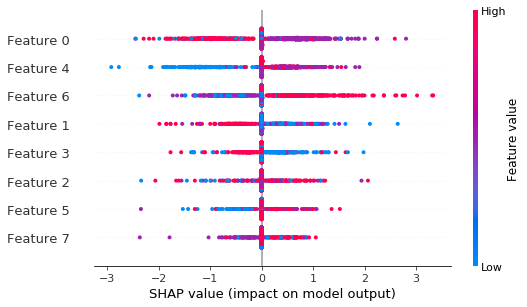

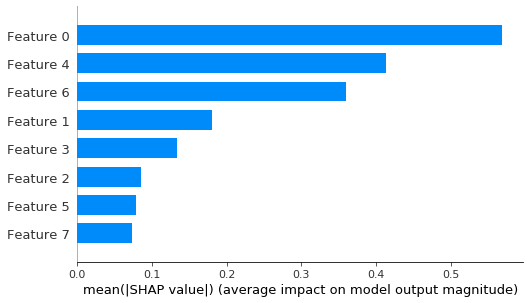

In [0]:
shap.summary_plot(shap_values3, X)
shap.summary_plot(shap_values3, X, plot_type="bar")

# Cross validation function

In [0]:
def get_cv(model,data,n_splits=10,cv_type = "KFold",verbose = True):  
  """ Cross validation to get CLL and accuracy and training time.
    :param data: data with dimension p+1 x n, to be cross validated.
                         where n is the number of examples,
                         and p is the number of features. Last column is target.   data has to be a list [[ ], [ ], [ ].... ]
    :return CLL, accuracy, training time for each folds.
  """

  if cv_type == "StratifiedKFold":
    cv = StratifiedKFold(n_splits= n_splits, shuffle=True, random_state=42)##The folds are made by preserving the percentage of samples for each class.
  else: 
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  
  X = np.array(model.get_X(data))## if data is array, then get_X return array. if data is list, get_X return list
  Y = np.array(model.get_Y(data)) ### Y array['1','0','']
  binarizer = MultiLabelBinarizer() ## for using recall and precision score
  binarizer.fit(Y)
  Accuracy = []
  Precision = []
  Recall = []
  CLL = []
  training_time = []
  for folder, (train_index, val_index) in enumerate(cv.split(X, Y)):#### X,Y are array, data is list
    X_val = X[val_index]
    y_val = Y[val_index] 
    model.fit(data[train_index]) ### whether data is list or array does not matter, only thing matters is label has to be same.
    y_pred_prob= model.predict(X_val)
    training_time.append(model.training_time)  
    y_pred_class = model.prob_to_class_general(y_pred_prob,model.C)
    accuracy = accuracy_score(y_val, y_pred_class)
    precision = precision_score(binarizer.transform(y_val), 
         binarizer.transform(y_pred_class), 
         average='macro')    
    recall = recall_score(binarizer.transform(y_val), 
         binarizer.transform(y_pred_class), 
         average='macro')
    cll = model.Conditional_log_likelihood_general(y_val,y_pred_prob,model.C)
    if verbose:
        print("accuracy in %s fold is %s" % (folder+1,accuracy))
        print("CLL in %s fold is %s" % (folder+1,cll))
        print("precision in %s fold is %s" % (folder+1,precision))
        print("recall in %s fold is %s" % (folder+1,recall))
        print("training time in %s fold is %s" % (folder+1,training_time[-1]))
        print(10*'__')
    CLL.append(cll)
    Accuracy.append(accuracy)
    Recall.append(recall)
    Precision.append(precision)
  return Accuracy, CLL, training_time,Precision,Recall

## P450

#### 10 folds stratified

In [0]:
Accuracy, CLL, _ = get_cv(nb,P450,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8645833333333334
CLL in 1 fold is -49.554528786770774
training time in 1 fold is 0.01297874400006549
____________________
accuracy in 2 fold is 0.8125
CLL in 2 fold is -61.723998465095484
training time in 2 fold is 0.010865021999961755
____________________
accuracy in 3 fold is 0.7708333333333334
CLL in 3 fold is -66.22240700602836
training time in 3 fold is 0.010416641999881904
____________________
accuracy in 4 fold is 0.7708333333333334
CLL in 4 fold is -59.82225364181568
training time in 4 fold is 0.010203637000131494
____________________
accuracy in 5 fold is 0.84375
CLL in 5 fold is -51.88744020971564
training time in 5 fold is 0.01006998800016845
____________________
accuracy in 6 fold is 0.8421052631578947
CLL in 6 fold is -54.791600053813056
training time in 6 fold is 0.010898560999976326
____________________
accuracy in 7 fold is 0.8
CLL in 7 fold is -62.15754303613411
training time in 7 fold is 0.010396657000001142
____________________
accuracy in 8 f

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt,P450,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8958333333333334
CLL in 1 fold is -42.65895853121772
training time in 1 fold is [4.04250197e-01 2.52208000e-04 2.79169960e-02]
____________________
accuracy in 2 fold is 0.7708333333333334
CLL in 2 fold is -66.43933414035064
training time in 2 fold is [4.08500006e-01 2.63857000e-04 2.99333630e-02]
____________________
accuracy in 3 fold is 0.84375
CLL in 3 fold is -52.98879982681865
training time in 3 fold is [4.00430654e-01 2.64342000e-04 2.79195160e-02]
____________________
accuracy in 4 fold is 0.84375
CLL in 4 fold is -54.0113723774487
training time in 4 fold is [3.97503693e-01 2.71191000e-04 2.86447610e-02]
____________________
accuracy in 5 fold is 0.8958333333333334
CLL in 5 fold is -42.62980958538322
training time in 5 fold is [4.00991462e-01 2.85200000e-04 2.86250030e-02]
____________________
accuracy in 6 fold is 0.8315789473684211
CLL in 6 fold is -53.67766481798398
training time in 6 fold is [3.96681121e-01 2.62350000e-04 2.94545750e-02]
____________

In [0]:
Accuracy, CLL, _ = get_cv(tan,P450,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9166666666666666
CLL in 1 fold is -40.684964991084605
training time in 1 fold is 0.03542151799979365
____________________
accuracy in 2 fold is 0.8125
CLL in 2 fold is -58.18400253181099
training time in 2 fold is 0.03046763500015004
____________________
accuracy in 3 fold is 0.8229166666666666
CLL in 3 fold is -54.40840078091216
training time in 3 fold is 0.02925864700000602
____________________
accuracy in 4 fold is 0.84375
CLL in 4 fold is -52.01230375781805
training time in 4 fold is 0.029759578000039255
____________________
accuracy in 5 fold is 0.8645833333333334
CLL in 5 fold is -41.69180609158545
training time in 5 fold is 0.0303653440000744
____________________
accuracy in 6 fold is 0.8421052631578947
CLL in 6 fold is -52.78541358094983
training time in 6 fold is 0.032568760999993174
____________________
accuracy in 7 fold is 0.8736842105263158
CLL in 7 fold is -47.11956958832829
training time in 7 fold is 0.032958215999997265
____________________
accur

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt_bag,P450,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8958333333333334
CLL in 1 fold is -40.51032658849228
training time in 1 fold is [4.22775465e-01 2.94925000e-04 3.04085301e-02]
____________________
accuracy in 2 fold is 0.7708333333333334
CLL in 2 fold is -65.05603277684698
training time in 2 fold is [4.21971651e-01 3.13687250e-04 3.03645905e-02]
____________________
accuracy in 3 fold is 0.875
CLL in 3 fold is -52.33277133422568
training time in 3 fold is [4.10066494e-01 2.73447250e-04 2.85989909e-02]
____________________
accuracy in 4 fold is 0.875
CLL in 4 fold is -52.28038525236224
training time in 4 fold is [3.85757127e-01 2.59488000e-04 2.71261926e-02]
____________________
accuracy in 5 fold is 0.90625
CLL in 5 fold is -41.32030729031753
training time in 5 fold is [3.98264963e-01 2.72587500e-04 2.81627925e-02]
____________________
accuracy in 6 fold is 0.8210526315789474
CLL in 6 fold is -51.65329858558617
training time in 6 fold is [3.97132832e-01 2.56164375e-04 2.85591125e-02]
____________________
accur

In [0]:
Accuracy, CLL, _ = get_cv(tan_bag,P450,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9166666666666666
CLL in 1 fold is -40.69714831571372
training time in 1 fold is 0.03176939150006319
____________________
accuracy in 2 fold is 0.8125
CLL in 2 fold is -58.14771923951132
training time in 2 fold is 0.03164930487497486
____________________
accuracy in 3 fold is 0.8229166666666666
CLL in 3 fold is -54.570994162820824
training time in 3 fold is 0.03105053450002515
____________________
accuracy in 4 fold is 0.84375
CLL in 4 fold is -52.054882054900816
training time in 4 fold is 0.03143098612508766
____________________
accuracy in 5 fold is 0.8645833333333334
CLL in 5 fold is -41.687601222188974
training time in 5 fold is 0.031126395124942974
____________________
accuracy in 6 fold is 0.8421052631578947
CLL in 6 fold is -52.765716396731314
training time in 6 fold is 0.03229328825000266
____________________
accuracy in 7 fold is 0.8736842105263158
CLL in 7 fold is -47.18312034453523
training time in 7 fold is 0.031164828249927723
____________________
ac

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt_tan_bag,P450,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8958333333333334
CLL in 1 fold is -40.08250292504435
training time in 1 fold is [3.81723707e-01 2.68905625e-04 2.69380778e-02]
____________________
accuracy in 2 fold is 0.78125
CLL in 2 fold is -63.348210539103604
training time in 2 fold is [3.73998342e-01 2.51192000e-04 2.62962106e-02]
____________________
accuracy in 3 fold is 0.875
CLL in 3 fold is -52.15275912634125
training time in 3 fold is [3.77667524e-01 2.68527875e-04 2.66288510e-02]
____________________
accuracy in 4 fold is 0.8645833333333334
CLL in 4 fold is -51.70934355328879
training time in 4 fold is [3.81011577e-01 2.56095625e-04 2.69373550e-02]
____________________
accuracy in 5 fold is 0.90625
CLL in 5 fold is -41.072787463790334
training time in 5 fold is [3.74450971e-01 2.79645625e-04 2.64589198e-02]
____________________
accuracy in 6 fold is 0.8315789473684211
CLL in 6 fold is -51.18387879499953
training time in 6 fold is [3.79854641e-01 2.58511500e-04 2.70981949e-02]
____________________
a

#### 10 folds K-folds

In [0]:
Accuracy, CLL, training_time = get_cv(nb,P450)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8020833333333334
CLL in 1 fold is -57.517146264103346
training time in 1 fold is 0.015016652999975122
____________________
accuracy in 2 fold is 0.75
CLL in 2 fold is -68.1715682108779
training time in 2 fold is 0.009780331999991176
____________________
accuracy in 3 fold is 0.78125
CLL in 3 fold is -64.3404765335945
training time in 3 fold is 0.009944034999989526
____________________
accuracy in 4 fold is 0.8958333333333334
CLL in 4 fold is -53.42218540005551
training time in 4 fold is 0.010029911000174252
____________________
accuracy in 5 fold is 0.8333333333333334
CLL in 5 fold is -53.8387193710917
training time in 5 fold is 0.009475789999896733
____________________
accuracy in 6 fold is 0.7894736842105263
CLL in 6 fold is -64.78206776273915
training time in 6 fold is 0.010567762999926344
____________________
accuracy in 7 fold is 0.8105263157894737
CLL in 7 fold is -62.93177657822839
training time in 7 fold is 0.01338441600000806
____________________
accura

In [0]:
Accuracy, CLL, training_time = get_cv(tan_mt,P450)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8854166666666666
CLL in 1 fold is -46.55818986810373
training time in 1 fold is [4.11615196e-01 2.57222000e-04 3.08314650e-02]
____________________
accuracy in 2 fold is 0.8645833333333334
CLL in 2 fold is -54.548794769067385
training time in 2 fold is [4.08056649e-01 3.53283000e-04 2.91585300e-02]
____________________
accuracy in 3 fold is 0.7916666666666666
CLL in 3 fold is -56.790309206956124
training time in 3 fold is [4.05783586e-01 2.83121000e-04 2.97966460e-02]
____________________
accuracy in 4 fold is 0.8958333333333334
CLL in 4 fold is -39.40655198073539
training time in 4 fold is [4.10182846e-01 2.76970000e-04 3.04969560e-02]
____________________
accuracy in 5 fold is 0.84375
CLL in 5 fold is -48.6211981823957
training time in 5 fold is [4.1688537e-01 3.3456900e-04 3.0955104e-02]
____________________
accuracy in 6 fold is 0.7894736842105263
CLL in 6 fold is -66.52490487586431
training time in 6 fold is [4.02003646e-01 2.57271000e-04 2.92207020e-02]
__

In [0]:
Accuracy,CLL,_ = get_cv(tan,P450)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8229166666666666
CLL in 1 fold is -55.859484583028035
training time in 1 fold is 0.03214012099988395
____________________
accuracy in 2 fold is 0.8541666666666666
CLL in 2 fold is -54.6870002971402
training time in 2 fold is 0.029763424000066152
____________________
accuracy in 3 fold is 0.8645833333333334
CLL in 3 fold is -50.858955717988486
training time in 3 fold is 0.029593705000024784
____________________
accuracy in 4 fold is 0.90625
CLL in 4 fold is -38.04638101612256
training time in 4 fold is 0.030484599999908824
____________________
accuracy in 5 fold is 0.84375
CLL in 5 fold is -49.000295029531145
training time in 5 fold is 0.028483834000098796
____________________
accuracy in 6 fold is 0.7789473684210526
CLL in 6 fold is -61.72447430375074
training time in 6 fold is 0.030094948999931148
____________________
accuracy in 7 fold is 0.8842105263157894
CLL in 7 fold is -50.39363673083368
training time in 7 fold is 0.029422164000152407
____________________

In [0]:
Accuracy,CLL,_ = get_cv(tan_mt_bag,P450)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.875
CLL in 1 fold is -47.926125601490014
training time in 1 fold is [3.84681140e-01 2.60505750e-04 2.83552982e-02]
____________________
accuracy in 2 fold is 0.875
CLL in 2 fold is -54.189240263708854
training time in 2 fold is [3.98834948e-01 2.61233625e-04 2.87306009e-02]
____________________
accuracy in 3 fold is 0.8125
CLL in 3 fold is -56.12435396120553
training time in 3 fold is [3.90501330e-01 2.66852125e-04 2.88537257e-02]
____________________
accuracy in 4 fold is 0.9166666666666666
CLL in 4 fold is -39.03597805384587
training time in 4 fold is [3.98517314e-01 2.58740750e-04 2.86369734e-02]
____________________
accuracy in 5 fold is 0.8541666666666666
CLL in 5 fold is -46.85839734494776
training time in 5 fold is [3.91998547e-01 2.93299375e-04 2.87389156e-02]
____________________
accuracy in 6 fold is 0.7789473684210526
CLL in 6 fold is -65.64033208260548
training time in 6 fold is [3.97666179e-01 2.70909750e-04 2.86780026e-02]
____________________
accu

In [0]:
Accuracy,CLL,_ = get_cv(tan_bag,P450)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8229166666666666
CLL in 1 fold is -55.871057957696706
training time in 1 fold is 0.029653423749977037
____________________
accuracy in 2 fold is 0.8541666666666666
CLL in 2 fold is -54.70279598742377
training time in 2 fold is 0.0293647875000147
____________________
accuracy in 3 fold is 0.8645833333333334
CLL in 3 fold is -50.893116062291625
training time in 3 fold is 0.030122227375073862
____________________
accuracy in 4 fold is 0.90625
CLL in 4 fold is -38.02803981610573
training time in 4 fold is 0.029784258250060702
____________________
accuracy in 5 fold is 0.84375
CLL in 5 fold is -49.07240609733496
training time in 5 fold is 0.03041588850004473
____________________
accuracy in 6 fold is 0.7684210526315789
CLL in 6 fold is -61.734038654100054
training time in 6 fold is 0.03009965762495881
____________________
accuracy in 7 fold is 0.8842105263157894
CLL in 7 fold is -50.397086205430625
training time in 7 fold is 0.03017260912500319
____________________
a

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt_tan_bag,P450)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.875
CLL in 1 fold is -48.53587560336295
training time in 1 fold is [3.74584932e-01 3.00913500e-04 2.67080911e-02]
____________________
accuracy in 2 fold is 0.8645833333333334
CLL in 2 fold is -53.752582947340386
training time in 2 fold is [3.74996447e-01 2.48412875e-04 2.58099997e-02]
____________________
accuracy in 3 fold is 0.8229166666666666
CLL in 3 fold is -54.85552228051796
training time in 3 fold is [3.75339269e-01 2.71999000e-04 2.58456209e-02]
____________________
accuracy in 4 fold is 0.9166666666666666
CLL in 4 fold is -38.61447090365611
training time in 4 fold is [3.79468900e-01 3.04105375e-04 2.85283475e-02]
____________________
accuracy in 5 fold is 0.8541666666666666
CLL in 5 fold is -46.847232462532816
training time in 5 fold is [3.73280807e-01 2.78207125e-04 2.55478968e-02]
____________________
accuracy in 6 fold is 0.7789473684210526
CLL in 6 fold is -64.08672631715861
training time in 6 fold is [3.70281620e-01 2.48445500e-04 2.60881868e-02]


## lactamase

### 10 folds stratified

In [0]:
Accuracy, CLL, _ = get_cv(nb,lactamase,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8571428571428571
CLL in 1 fold is -26.081281797331926
training time in 1 fold is 0.008293603999987909
____________________
accuracy in 2 fold is 0.8571428571428571
CLL in 2 fold is -28.944311197023303
training time in 2 fold is 0.0060605620000018234
____________________
accuracy in 3 fold is 0.8363636363636363
CLL in 3 fold is -26.823479280675066
training time in 3 fold is 0.006935699999999656
____________________
accuracy in 4 fold is 0.8
CLL in 4 fold is -28.49951923362409
training time in 4 fold is 0.005663108000007355
____________________
accuracy in 5 fold is 0.8
CLL in 5 fold is -24.7219849923127
training time in 5 fold is 0.005611485999992283
____________________
accuracy in 6 fold is 0.8727272727272727
CLL in 6 fold is -23.948046475037174
training time in 6 fold is 0.005537261999990051
____________________
accuracy in 7 fold is 0.8545454545454545
CLL in 7 fold is -33.75623095466681
training time in 7 fold is 0.005945261999997342
____________________
accu

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt,lactamase,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9642857142857143
CLL in 1 fold is -13.29321220099823
training time in 1 fold is [3.32989087e-01 2.52074000e-04 1.56509780e-02]
____________________
accuracy in 2 fold is 0.875
CLL in 2 fold is -24.416499065431637
training time in 2 fold is [3.25158449e-01 2.39818000e-04 1.56571960e-02]
____________________
accuracy in 3 fold is 0.9454545454545454
CLL in 3 fold is -14.870702543056955
training time in 3 fold is [3.29780323e-01 2.62030000e-04 1.54986050e-02]
____________________
accuracy in 4 fold is 0.8909090909090909
CLL in 4 fold is -20.672059658261357
training time in 4 fold is [3.35792832e-01 2.48411000e-04 1.80263950e-02]
____________________
accuracy in 5 fold is 0.8363636363636363
CLL in 5 fold is -23.356147970596417
training time in 5 fold is [3.20221001e-01 2.44998000e-04 1.53329440e-02]
____________________
accuracy in 6 fold is 0.8363636363636363
CLL in 6 fold is -25.610493908671515
training time in 6 fold is [3.14479833e-01 2.47005000e-04 1.59942220e-0

In [0]:
Accuracy, CLL, _ = get_cv(tan,lactamase,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8571428571428571
CLL in 1 fold is -21.4732080032541
training time in 1 fold is 0.017252940999995303
____________________
accuracy in 2 fold is 0.875
CLL in 2 fold is -29.487010028969067
training time in 2 fold is 0.015780577000001017
____________________
accuracy in 3 fold is 0.8363636363636363
CLL in 3 fold is -27.252642913836905
training time in 3 fold is 0.01571899699999335
____________________
accuracy in 4 fold is 0.7818181818181819
CLL in 4 fold is -30.095926518342885
training time in 4 fold is 0.016605033999994134
____________________
accuracy in 5 fold is 0.7818181818181819
CLL in 5 fold is -26.591439665750737
training time in 5 fold is 0.01702297100000294
____________________
accuracy in 6 fold is 0.8545454545454545
CLL in 6 fold is -22.756688737830377
training time in 6 fold is 0.015335834999987696
____________________
accuracy in 7 fold is 0.8363636363636363
CLL in 7 fold is -36.365525214086766
training time in 7 fold is 0.01593247799999631
__________

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt_bag,lactamase,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9642857142857143
CLL in 1 fold is -13.761953067252225
training time in 1 fold is [3.24481117e-01 2.47288375e-04 1.51566736e-02]
____________________
accuracy in 2 fold is 0.9285714285714286
CLL in 2 fold is -22.26812384951358
training time in 2 fold is [3.25225094e-01 2.49586875e-04 1.54988929e-02]
____________________
accuracy in 3 fold is 0.9454545454545454
CLL in 3 fold is -15.251824093703755
training time in 3 fold is [3.33449354e-01 2.43292250e-04 1.57405555e-02]
____________________
accuracy in 4 fold is 0.8727272727272727
CLL in 4 fold is -20.12998879430538
training time in 4 fold is [3.28815929e-01 2.46905500e-04 1.52963369e-02]
____________________
accuracy in 5 fold is 0.8363636363636363
CLL in 5 fold is -22.19372471261311
training time in 5 fold is [3.22354730e-01 2.47093750e-04 1.49399766e-02]
____________________
accuracy in 6 fold is 0.8363636363636363
CLL in 6 fold is -24.161382169606267
training time in 6 fold is [3.10895582e-01 2.43419125e-04 1.

In [0]:
Accuracy, CLL, _ = get_cv(tan_bag,lactamase,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8571428571428571
CLL in 1 fold is -21.502380204204144
training time in 1 fold is 0.01729175587499654
____________________
accuracy in 2 fold is 0.875
CLL in 2 fold is -29.535624884018556
training time in 2 fold is 0.016164974124993847
____________________
accuracy in 3 fold is 0.8363636363636363
CLL in 3 fold is -27.18393422147956
training time in 3 fold is 0.015912318374994072
____________________
accuracy in 4 fold is 0.7818181818181819
CLL in 4 fold is -30.09605296476696
training time in 4 fold is 0.016317816375000405
____________________
accuracy in 5 fold is 0.7818181818181819
CLL in 5 fold is -26.511169201654493
training time in 5 fold is 0.015814133125008567
____________________
accuracy in 6 fold is 0.8545454545454545
CLL in 6 fold is -22.562811604724956
training time in 6 fold is 0.017247139625006014
____________________
accuracy in 7 fold is 0.8363636363636363
CLL in 7 fold is -36.49756725180262
training time in 7 fold is 0.015158832750000073
_________

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt_tan_bag,lactamase,cv_type="StratifiedKFold")
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9642857142857143
CLL in 1 fold is -14.26670092051921
training time in 1 fold is [3.26602717e-01 2.48763500e-04 1.55406926e-02]
____________________
accuracy in 2 fold is 0.9107142857142857
CLL in 2 fold is -22.109103416166477
training time in 2 fold is [3.24994974e-01 2.53376125e-04 1.52786154e-02]
____________________
accuracy in 3 fold is 0.9636363636363636
CLL in 3 fold is -16.136858992898585
training time in 3 fold is [3.26442543e-01 2.47363875e-04 1.52463197e-02]
____________________
accuracy in 4 fold is 0.8727272727272727
CLL in 4 fold is -20.70326035730045
training time in 4 fold is [3.2680085e-01 2.5892925e-04 1.5050663e-02]
____________________
accuracy in 5 fold is 0.8363636363636363
CLL in 5 fold is -21.98686984065975
training time in 5 fold is [3.21609819e-01 2.43919750e-04 1.51175286e-02]
____________________
accuracy in 6 fold is 0.8363636363636363
CLL in 6 fold is -23.205537431653624
training time in 6 fold is [3.24844996e-01 2.64127875e-04 1.513

### 10 folds K-folds

In [0]:
Accuracy, CLL, _ = get_cv(nb,lactamase)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.875
CLL in 1 fold is -26.97175334366014
training time in 1 fold is 0.010518913999987944
____________________
accuracy in 2 fold is 0.9107142857142857
CLL in 2 fold is -19.791931161262852
training time in 2 fold is 0.005187372999984063
____________________
accuracy in 3 fold is 0.8181818181818182
CLL in 3 fold is -25.25170879090418
training time in 3 fold is 0.005099664999988818
____________________
accuracy in 4 fold is 0.9090909090909091
CLL in 4 fold is -19.86403033918379
training time in 4 fold is 0.005232939000023862
____________________
accuracy in 5 fold is 0.8909090909090909
CLL in 5 fold is -27.556071932265798
training time in 5 fold is 0.005603204999999889
____________________
accuracy in 6 fold is 0.8181818181818182
CLL in 6 fold is -28.357096092113306
training time in 6 fold is 0.005057407999998986
____________________
accuracy in 7 fold is 0.7636363636363637
CLL in 7 fold is -33.58477925689328
training time in 7 fold is 0.005586764000014455
_________

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt,lactamase)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9285714285714286
CLL in 1 fold is -14.530692699471455
training time in 1 fold is [3.43818156e-01 2.45035000e-04 1.55102650e-02]
____________________
accuracy in 2 fold is 0.9642857142857143
CLL in 2 fold is -11.353701614711582
training time in 2 fold is [3.30810671e-01 2.34213000e-04 1.62527100e-02]
____________________
accuracy in 3 fold is 0.8181818181818182
CLL in 3 fold is -32.343225944163294
training time in 3 fold is [3.33284282e-01 2.45469000e-04 1.60198190e-02]
____________________
accuracy in 4 fold is 0.9272727272727272
CLL in 4 fold is -15.10718618808436
training time in 4 fold is [3.32353789e-01 2.50427000e-04 1.59544880e-02]
____________________
accuracy in 5 fold is 0.8909090909090909
CLL in 5 fold is -19.110974321641113
training time in 5 fold is [3.35802064e-01 2.35344000e-04 1.58692880e-02]
____________________
accuracy in 6 fold is 0.9090909090909091
CLL in 6 fold is -23.30169261958045
training time in 6 fold is [3.54017472e-01 2.54370000e-04 1

In [0]:
Accuracy, CLL, _ = get_cv(tan,lactamase)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8392857142857143
CLL in 1 fold is -27.10722475132258
training time in 1 fold is 0.019687987999986944
____________________
accuracy in 2 fold is 0.875
CLL in 2 fold is -20.673034235272922
training time in 2 fold is 0.017861586999998735
____________________
accuracy in 3 fold is 0.8181818181818182
CLL in 3 fold is -27.839107695749757
training time in 3 fold is 0.015328496999984509
____________________
accuracy in 4 fold is 0.9090909090909091
CLL in 4 fold is -25.437577410172132
training time in 4 fold is 0.01620654199999194
____________________
accuracy in 5 fold is 0.8181818181818182
CLL in 5 fold is -29.73510284461702
training time in 5 fold is 0.014946872999985317
____________________
accuracy in 6 fold is 0.8727272727272727
CLL in 6 fold is -25.96303021283931
training time in 6 fold is 0.01576461500002324
____________________
accuracy in 7 fold is 0.8363636363636363
CLL in 7 fold is -31.45942904461455
training time in 7 fold is 0.01553102799999806
____________

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt_bag,lactamase)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9285714285714286
CLL in 1 fold is -14.798899975173397
training time in 1 fold is [3.30987818e-01 2.52382500e-04 1.69104755e-02]
____________________
accuracy in 2 fold is 0.9642857142857143
CLL in 2 fold is -11.770376562035876
training time in 2 fold is [3.22429735e-01 2.47941375e-04 1.55434825e-02]
____________________
accuracy in 3 fold is 0.8545454545454545
CLL in 3 fold is -30.611296032426164
training time in 3 fold is [3.21752142e-01 2.37294125e-04 1.56972193e-02]
____________________
accuracy in 4 fold is 0.9272727272727272
CLL in 4 fold is -15.550604270900592
training time in 4 fold is [3.28153497e-01 2.41847125e-04 1.63285421e-02]
____________________
accuracy in 5 fold is 0.8909090909090909
CLL in 5 fold is -18.19118544028877
training time in 5 fold is [3.30588272e-01 2.49690000e-04 1.64711387e-02]
____________________
accuracy in 6 fold is 0.9272727272727272
CLL in 6 fold is -21.570998478464052
training time in 6 fold is [3.29580427e-01 3.19173500e-04 

In [0]:
Accuracy, CLL, _ = get_cv(tan_bag,lactamase)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.8392857142857143
CLL in 1 fold is -27.208693106570855
training time in 1 fold is 0.017586994500003783
____________________
accuracy in 2 fold is 0.875
CLL in 2 fold is -20.726072672274167
training time in 2 fold is 0.01687094375000342
____________________
accuracy in 3 fold is 0.8181818181818182
CLL in 3 fold is -27.752675936381042
training time in 3 fold is 0.01584607487500378
____________________
accuracy in 4 fold is 0.9090909090909091
CLL in 4 fold is -25.458947437557637
training time in 4 fold is 0.01595711999999594
____________________
accuracy in 5 fold is 0.8181818181818182
CLL in 5 fold is -29.673204165877564
training time in 5 fold is 0.015947081250001105
____________________
accuracy in 6 fold is 0.8727272727272727
CLL in 6 fold is -26.06157739852362
training time in 6 fold is 0.01617524399998871
____________________
accuracy in 7 fold is 0.8363636363636363
CLL in 7 fold is -31.61701994938886
training time in 7 fold is 0.016398133624999645
___________

In [0]:
Accuracy, CLL, _ = get_cv(tan_mt_tan_bag,lactamase)
print(mean(Accuracy))
print(mean(CLL))

accuracy in 1 fold is 0.9285714285714286
CLL in 1 fold is -15.705365553020686
training time in 1 fold is [3.33589807e-01 2.76618250e-04 1.64964305e-02]
____________________
accuracy in 2 fold is 0.9642857142857143
CLL in 2 fold is -12.421490057000051
training time in 2 fold is [3.37918607e-01 2.59305250e-04 1.60105620e-02]
____________________
accuracy in 3 fold is 0.8727272727272727
CLL in 3 fold is -28.082411950829858
training time in 3 fold is [3.33806112e-01 2.43963750e-04 1.58092191e-02]
____________________
accuracy in 4 fold is 0.9272727272727272
CLL in 4 fold is -16.080982169222064
training time in 4 fold is [3.26950570e-01 2.53747000e-04 1.56953609e-02]
____________________
accuracy in 5 fold is 0.9090909090909091
CLL in 5 fold is -18.694231539579985
training time in 5 fold is [3.33750329e-01 2.43028750e-04 1.58891745e-02]
____________________
accuracy in 6 fold is 0.9454545454545454
CLL in 6 fold is -21.037837340501145
training time in 6 fold is [3.31684694e-01 2.80288750e-04

## Lymph

### 10 folds K-folds

In [47]:
nb = NB()
Accuracy, CLL, _, Precision,Recall = get_cv(nb,lymph)
print(mean(Accuracy))
print(mean(CLL))
print(mean(Recall))
print(mean(Precision))

accuracy in 1 fold is 0.8666666666666667
CLL in 1 fold is -8.358321352424156
precision in 1 fold is 0.8251748251748251
recall in 1 fold is 0.8251748251748251
training time in 1 fold is 0.01055686499999986
____________________
accuracy in 2 fold is 0.8
CLL in 2 fold is -7.71680217163437
precision in 2 fold is 0.8461538461538463
recall in 2 fold is 0.7953296703296703
training time in 2 fold is 0.005723962000001137
____________________
accuracy in 3 fold is 0.8571428571428571
CLL in 3 fold is -14.627094639835997
precision in 3 fold is 0.8846153846153848
recall in 3 fold is 0.8846153846153848
training time in 3 fold is 0.0050701360000005025
____________________
accuracy in 4 fold is 0.9285714285714286
CLL in 4 fold is -3.1601902160889854
precision in 4 fold is 0.9670329670329672
recall in 4 fold is 0.9230769230769231
training time in 4 fold is 0.00544817200000125
____________________
accuracy in 5 fold is 1.0
CLL in 5 fold is -1.9299940895581436
precision in 5 fold is 1.0
recall in 5 fold 

In [49]:
tan_mt = TAN_MT()
Accuracy, CLL, _, Precision,Recall = get_cv(tan_mt,lymph)
print(mean(Accuracy))
print(mean(CLL))
print(mean(Recall))
print(mean(Precision))

accuracy in 1 fold is 1.0
CLL in 1 fold is -2.4419915106527053
precision in 1 fold is 1.0
recall in 1 fold is 1.0
training time in 1 fold is [1.46254608 0.00205358 0.01664665]
____________________
accuracy in 2 fold is 0.7333333333333333
CLL in 2 fold is -10.808528879217949
precision in 2 fold is 0.7564102564102565
recall in 2 fold is 0.8255494505494506
training time in 2 fold is [1.47042102 0.00182601 0.01559631]
____________________
accuracy in 3 fold is 0.7857142857142857
CLL in 3 fold is -13.672049124830979
precision in 3 fold is 0.8170940170940172
recall in 3 fold is 0.846153846153846
training time in 3 fold is [1.44258483 0.00184496 0.01706695]
____________________
accuracy in 4 fold is 0.9285714285714286
CLL in 4 fold is -3.3168595216934182
precision in 4 fold is 0.9670329670329672
recall in 4 fold is 0.9230769230769231
training time in 4 fold is [1.45102714 0.00202465 0.01594813]
____________________
accuracy in 5 fold is 1.0
CLL in 5 fold is -2.391125101552298
precision in 5 f

In [50]:
tan_mt_bag = TAN_MT_bagging()
Accuracy, CLL, _, Precision,Recall = get_cv(tan_mt_bag,lymph)
print(mean(Accuracy))
print(mean(CLL))
print(mean(Recall))
print(mean(Precision))

accuracy in 1 fold is 0.9333333333333333
CLL in 1 fold is -2.6100678311045344
precision in 1 fold is 0.8769230769230769
recall in 1 fold is 0.979020979020979
training time in 1 fold is [1.4298637  0.00190718 0.01698558]
____________________
accuracy in 2 fold is 0.8
CLL in 2 fold is -9.456573775309467
precision in 2 fold is 0.8131868131868133
recall in 2 fold is 0.8543956043956045
training time in 2 fold is [1.433966   0.00193391 0.0169238 ]
____________________
accuracy in 3 fold is 0.8571428571428571
CLL in 3 fold is -11.9849190832695
precision in 3 fold is 0.8846153846153848
recall in 3 fold is 0.8846153846153848
training time in 3 fold is [1.43404011 0.00199152 0.01771995]
____________________
accuracy in 4 fold is 0.9285714285714286
CLL in 4 fold is -3.4160170300304613
precision in 4 fold is 0.9670329670329672
recall in 4 fold is 0.9230769230769231
training time in 4 fold is [1.43195124 0.00195863 0.01703302]
____________________
accuracy in 5 fold is 1.0
CLL in 5 fold is -2.34739

## Vote

### 10 folds K fold

In [51]:
nb = NB()
Accuracy, CLL, _, Precision,Recall = get_cv(nb,vote)
print(mean(Accuracy))
print(mean(CLL))
print(mean(Recall))
print(mean(Precision))

accuracy in 1 fold is 0.8863636363636364
CLL in 1 fold is -37.284961554591774
precision in 1 fold is 0.9122153209109733
recall in 1 fold is 0.9367521367521369
training time in 1 fold is 0.017580128000020068
____________________
accuracy in 2 fold is 0.9090909090909091
CLL in 2 fold is -39.28535670742011
precision in 2 fold is 0.9416666666666665
recall in 2 fold is 0.9053968253968255
training time in 2 fold is 0.013429302999952597
____________________
accuracy in 3 fold is 0.9545454545454546
CLL in 3 fold is -22.997995307863793
precision in 3 fold is 0.9625396825396827
recall in 3 fold is 0.9625396825396827
training time in 3 fold is 0.012661421000018436
____________________
accuracy in 4 fold is 0.9318181818181818
CLL in 4 fold is -19.592309663754538
precision in 4 fold is 0.9404761904761904
recall in 4 fold is 0.9549425287356322
training time in 4 fold is 0.012378365999950347
____________________
accuracy in 5 fold is 0.8636363636363636
CLL in 5 fold is -51.8476598160837
precision in 

In [52]:
tan_mt = TAN_MT()
Accuracy, CLL, _, Precision,Recall = get_cv(tan_mt,vote)
print(mean(Accuracy))
print(mean(CLL))
print(mean(Recall))
print(mean(Precision))

accuracy in 1 fold is 0.9545454545454546
CLL in 1 fold is -5.651605479270875
precision in 1 fold is 0.9675213675213676
recall in 1 fold is 0.9675213675213676
training time in 1 fold is [1.33851593 0.00147416 0.03232977]
____________________
accuracy in 2 fold is 0.9090909090909091
CLL in 2 fold is -8.64374946770916
precision in 2 fold is 0.9416666666666665
recall in 2 fold is 0.9053968253968255
training time in 2 fold is [1.31928815 0.0015262  0.03216212]
____________________
accuracy in 3 fold is 0.9772727272727273
CLL in 3 fold is -8.049071445680122
precision in 3 fold is 0.9733333333333334
recall in 3 fold is 0.9911111111111112
training time in 3 fold is [1.3279865  0.00139782 0.03338612]
____________________
accuracy in 4 fold is 0.9545454545454546
CLL in 4 fold is -2.9463722543158846
precision in 4 fold is 0.9641379310344826
recall in 4 fold is 0.9641379310344826
training time in 4 fold is [1.39838387 0.00159934 0.0319833 ]
____________________
accuracy in 5 fold is 0.863636363636

In [53]:
tan_mt_bag = TAN_MT_bagging()
Accuracy, CLL, _, Precision,Recall = get_cv(tan_mt_bag,vote)
print(mean(Accuracy))
print(mean(CLL))
print(mean(Recall))
print(mean(Precision))

accuracy in 1 fold is 0.9545454545454546
CLL in 1 fold is -6.5316119415229945
precision in 1 fold is 0.9675213675213676
recall in 1 fold is 0.9675213675213676
training time in 1 fold is [1.32176704 0.00141592 0.03057961]
____________________
accuracy in 2 fold is 0.9090909090909091
CLL in 2 fold is -8.36531946605065
precision in 2 fold is 0.9416666666666665
recall in 2 fold is 0.9053968253968255
training time in 2 fold is [1.31551864 0.00139733 0.03086756]
____________________
accuracy in 3 fold is 0.9772727272727273
CLL in 3 fold is -7.868391824468047
precision in 3 fold is 0.9733333333333334
recall in 3 fold is 0.9911111111111112
training time in 3 fold is [1.31416848 0.00144191 0.03094949]
____________________
accuracy in 4 fold is 0.9772727272727273
CLL in 4 fold is -2.855551494435339
precision in 4 fold is 0.975
recall in 4 fold is 0.9908045977011494
training time in 4 fold is [1.31213342 0.00143053 0.03172032]
____________________
accuracy in 5 fold is 0.8636363636363636
CLL in 5